Author: Shan Qu, Delft University of Technology

First created: 4 April 2021

Product: credit modeling --- training the model using XGBoost


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv, DMatrix

%run helpers.ipynb

pd.set_option('display.max_columns', 20)
seed = 143

import warnings
warnings.filterwarnings("ignore")

model = XGBClassifier()

In [2]:
df_X_train = pd.read_csv('df_X_train.csv')
df_X_val = pd.read_csv('df_X_val.csv')
df_y_train = pd.read_csv('df_y_train.csv')
df_y_val = pd.read_csv('df_y_val.csv')
print(df_X_train.info())
print(df_y_train.info())

# drop the unnamed ID column
df_X_train.drop('Unnamed: 0', axis=1, inplace=True)
df_X_val.drop('Unnamed: 0', axis=1, inplace=True)
df_y_train.drop('Unnamed: 0', axis=1, inplace=True)
df_y_val.drop('Unnamed: 0', axis=1, inplace=True)

df_X_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          506 non-null    int64  
 1   Age                 506 non-null    float64
 2   Credit amount       506 non-null    float64
 3   Duration            506 non-null    float64
 4   intercept           506 non-null    float64
 5   Sex_0               506 non-null    float64
 6   Job_0               506 non-null    float64
 7   Job_1               506 non-null    float64
 8   Job_2               506 non-null    float64
 9   Housing_0           506 non-null    float64
 10  Housing_1           506 non-null    float64
 11  Saving accounts_0   506 non-null    float64
 12  Saving accounts_1   506 non-null    float64
 13  Saving accounts_2   506 non-null    float64
 14  Saving accounts_3   506 non-null    float64
 15  Checking account_0  506 non-null    float64
 16  Checking

,Age,Credit amount,Duration,intercept,Sex_0,Job_0,Job_1,Job_2,Housing_0,Housing_1,...,Checking account_0,Checking account_1,Checking account_2,Purpose_0,Purpose_1,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6
0,0.089286,0.453230,0.647059,0.0,0.0,1.0,0.5,0.5,1.0,0.5,...,0.5,1.0,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.5
1,0.589286,0.108562,0.294118,0.0,1.0,1.0,0.5,0.5,1.0,0.5,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5
2,0.178571,0.170959,0.250000,0.0,0.0,1.0,0.5,0.5,1.0,0.5,...,1.0,0.5,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5
3,0.196429,0.204083,0.470588,0.0,1.0,0.5,0.5,1.0,1.0,0.5,...,1.0,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.5,0.5
4,0.982143,0.175966,0.014706,0.0,1.0,0.5,1.0,0.5,1.0,0.5,...,0.5,0.5,1.0,0.5,0.5,0.5,0.5,1.0,0.5,0.5


#### 2.1 Fine tune parameters

**Tune XGBoost hyperparameters step by step:**

Choose a relatively high learning rate (0.1). Determine the optimum number of trees for this learning rate.

Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees.

Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

Lower the learning rate and decide the optimal parameters.

Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

0.8003952569169961
0.8936946366917151
38


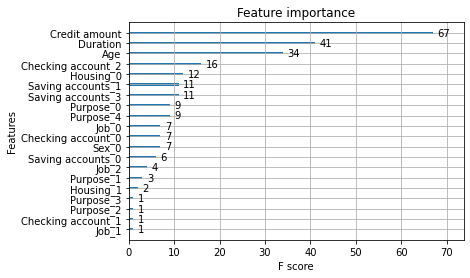

In [3]:
# Tune n_estimators
model = XGBClassifier(learning_rate = 0.1)
Dtrain = DMatrix(df_X_train.values, label=df_y_train.values)
cvresult = cv(model.get_xgb_params(), Dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)

model.set_params(n_estimators=cvresult.shape[0])
model.fit(df_X_train, df_y_train, eval_metric='auc')
        
preds = model.predict(df_X_train)
preds_prob = model.predict_proba(df_X_train)[:,1]
        
print(accuracy_score(df_y_train.values, preds))
print(roc_auc_score(df_y_train, preds_prob))
print(model.get_params()['n_estimators'])       

plot_importance(model, importance_type = 'weight')
plt.show()


In [4]:
# Tune max_depth, min_child_weight
model = XGBClassifier(learning_rate = 0.1, n_estimators=38)
hyperparam_grid_1 = {'max_depth': range(3,20,2),
                     'min_child_weight': range(1,7,2)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_1, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)


Fitting 15 folds for each of 27 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7580481865948996
{'max_depth': 3, 'min_child_weight': 5}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   18.0s finished


In [5]:
# Fine tune max_depth, min_child_weight
model = XGBClassifier(learning_rate = 0.1, n_estimators=38)
hyperparam_grid_1 = {'max_depth': [2, 3, 4, 5],
                     'min_child_weight': [4, 5, 6]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_1, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 12 candidates, totalling 180 fits
0.758961937716263
{'max_depth': 4, 'min_child_weight': 6}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    4.8s finished


In [6]:
# Tune gamma
model = XGBClassifier(learning_rate = 0.1, n_estimators=38
                      , max_depth = 4, min_child_weight = 6)
hyperparam_grid_2 = {'gamma': np.arange(0, 0.8, 0.02)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_2, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 40 candidates, totalling 600 fits
0.7596893502499039
{'gamma': 0.32}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.32,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   16.8s finished


In [7]:
# Tune subsample, colsample_bytree
model = XGBClassifier(learning_rate = 0.1, n_estimators=38, 
                      max_depth = 4, min_child_weight = 6, 
                      gamma = 0.32)
hyperparam_grid_3 = {'subsample': np.arange(0.5, 1, 0.1),
                     'colsample_bytree': np.arange(0.5, 1, 0.1)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_3, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 25 candidates, totalling 375 fits
0.761108035371011
{'colsample_bytree': 0.5, 'subsample': 0.7999999999999999}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.32,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7999999999999999, verbosity=1)


[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   10.0s finished


In [8]:
# Fine tune subsample, colsample_bytree
model = XGBClassifier(learning_rate = 0.1, n_estimators=38, 
                      max_depth = 4, min_child_weight = 6, 
                      gamma = 0.32)
hyperparam_grid_3 = {'subsample': np.arange(0.7, 0.9, 0.05),
                     'colsample_bytree': np.arange(0.3, 0.6, 0.05)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_3, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 30 candidates, totalling 450 fits
0.761108035371011
{'colsample_bytree': 0.49999999999999994, 'subsample': 0.8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.49999999999999994,
              gamma=0.32, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   10.3s finished


In [9]:
# Tune reg_alpha
model = XGBClassifier(learning_rate = 0.1, n_estimators=38, 
                      max_depth = 4, min_child_weight = 6, 
                      gamma = 0.32, 
                      colsample_bytree = 0.5, subsample = 0.8)
hyperparam_grid_4 = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_4, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 5 candidates, totalling 75 fits
0.7614801999231064
{'reg_alpha': 0.1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.32,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.7s finished


In [10]:
# Tune reg_alpha
model = XGBClassifier(learning_rate = 0.1, n_estimators=38, 
                      max_depth = 4, min_child_weight = 6, 
                      gamma = 0.32, 
                      colsample_bytree = 0.5, subsample = 0.8)
hyperparam_grid_4 = {'reg_alpha': np.arange(0.05, 0.15, 0.01)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_4, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 10 candidates, totalling 150 fits
0.7618169934640523
{'reg_alpha': 0.07}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.32,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.07, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    3.6s finished


In [11]:
model_bestparam = XGBClassifier(learning_rate = 0.1, n_estimators=38, 
                      max_depth = 4, min_child_weight = 6, 
                      gamma = 0.32, 
                      colsample_bytree = 0.5, subsample = 0.8,
                      reg_alpha = 0.07)
model_bestparam.fit(df_X_train, np.ravel(df_y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.32,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.07, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

### 2.2 Fitting and predicting using the selected hyperparameters and visualize the results

[[105  48]
 [ 13  34]]
              precision    recall  f1-score   support

        good       0.89      0.69      0.77       153
         bad       0.41      0.72      0.53        47

    accuracy                           0.69       200
   macro avg       0.65      0.70      0.65       200
weighted avg       0.78      0.69      0.72       200

0.7048393825615353


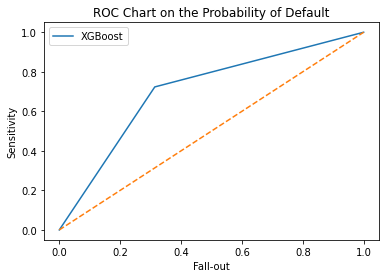

In [12]:
preds = model_bestparam.predict_proba(df_X_val)
df_preds = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.5
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds['Risk_pred']))
print(classification_report(df_y_val, df_preds['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds['Risk_pred']))

plot_roc_PD(df_preds, df_y_val, 'XGBoost')
plt.show()

### 2.3 Select proper threshold
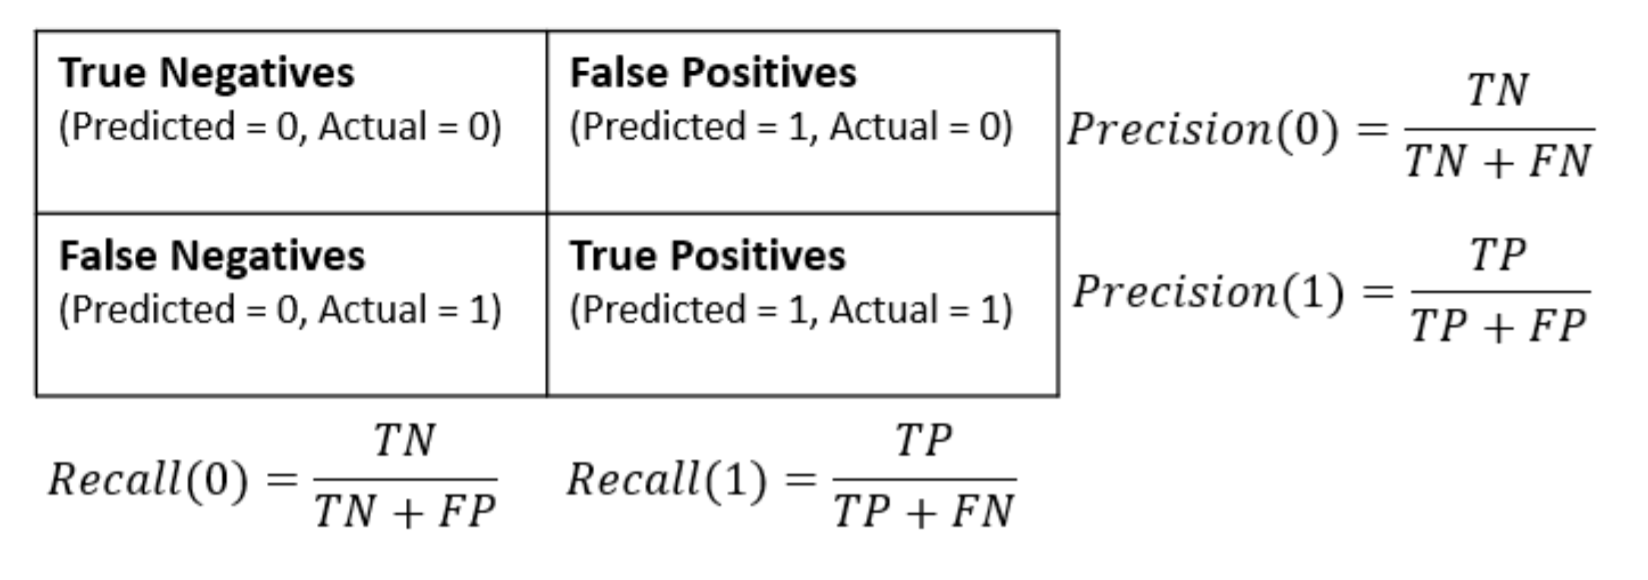

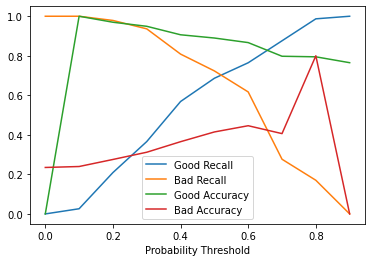

We can choose threshold = 0.63


In [13]:
plot_prob_thresh(df_preds, df_y_val)
plt.show()

print("We can choose threshold = 0.63")

### 2.4 Feature selection using feature_importances of the trained XGBoost

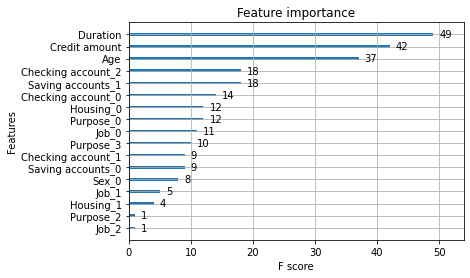

['Saving accounts_0', 'Checking account_1', 'Purpose_0', 'Checking account_0', 'Age', 'Housing_0', 'Credit amount', 'Duration', 'Saving accounts_1', 'Checking account_2', 'Purpose_3', 'Job_0']
12


In [14]:
plot_importance(model_bestparam, importance_type = 'weight')
plt.show()
#print(model_bestparam.get_booster().get_score(importance_type = 'weight'))

dict_importance = [model_bestparam.get_booster().get_score(importance_type = 'weight')]
df_importance = pd.DataFrame(dict_importance)

selected_columns = []
for index in np.arange(len(df_importance.columns)):
  if df_importance.iloc[0, index] >= 9:
    selected_columns.append(df_importance.columns[index])

print(selected_columns)
print(len(selected_columns))
df_X_train_selected = df_X_train[selected_columns]
df_X_val_selected = df_X_val[selected_columns]

In [15]:
model_bestparam.fit(df_X_train_selected, np.ravel(df_y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.32,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=38, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.07, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

[[106  47]
 [ 12  35]]
              precision    recall  f1-score   support

        good       0.90      0.69      0.78       153
         bad       0.43      0.74      0.54        47

    accuracy                           0.70       200
   macro avg       0.66      0.72      0.66       200
weighted avg       0.79      0.70      0.73       200

0.7187456542900849


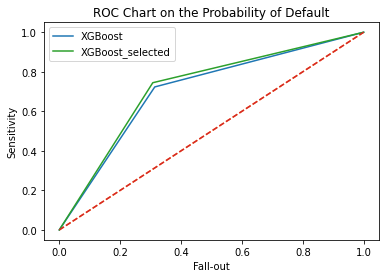

In [16]:
preds = model_bestparam.predict_proba(df_X_val_selected)
df_preds_selected = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.5
df_preds_selected['Risk_pred'] = df_preds_selected['prob_default'].apply(lambda x: 1 if x > threshold else 0)
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds_selected['Risk_pred']))
print(classification_report(df_y_val, df_preds_selected['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds_selected['Risk_pred']))

plot_roc_PD(df_preds, df_y_val, 'XGBoost')
plot_roc_PD(df_preds_selected, df_y_val, 'XGBoost_selected')
plt.show()

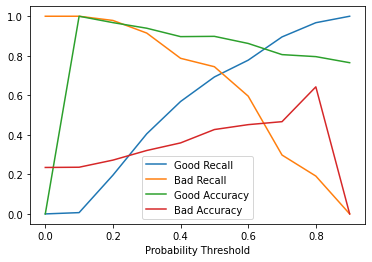

We can choose threshold = 0.62


In [17]:
plot_prob_thresh(df_preds_selected, df_y_val)
plt.show()
print("We can choose threshold = 0.62")